In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Stock prediction/archive/Google_Stock_Train (2010-2022).csv')



In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


In [23]:
df.shape

(3272, 7)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3272 non-null   object 
 1   Open       3272 non-null   float64
 2   High       3272 non-null   float64
 3   Low        3272 non-null   float64
 4   Close      3272 non-null   float64
 5   Adj Close  3272 non-null   float64
 6   Volume     3272 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 179.1+ KB


In [6]:
df1=df.reset_index()['Close']

In [7]:
df1

0       15.684434
1       15.615365
2       15.221722
3       14.867367
4       15.065566
          ...    
3267    89.230003
3268    87.389999
3269    86.019997
3270    88.449997
3271    88.230003
Name: Close, Length: 3272, dtype: float64

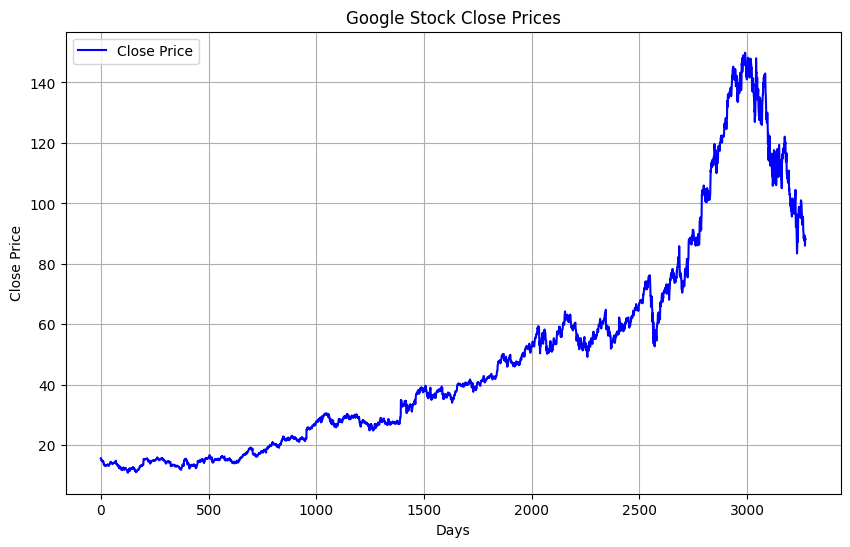

In [9]:
import matplotlib.pyplot as plt

# Plotting the 'close' prices
plt.figure(figsize=(10, 6))
plt.plot(df1, color='blue', label='Close Price')
plt.title('Google Stock Close Prices')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [10]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
df1_scaled = scaler.fit_transform(np.array(df1).reshape(-1,1))

## Splitting dataset into train and test split
training_size = int(len(df1_scaled) * 0.7)
test_size = len(df1_scaled) - training_size
train_data, test_data = df1_scaled[0:training_size,:], df1_scaled[training_size:len(df1_scaled),:1]

# Function to create dataset with sliding window
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i+time_step), 0]  # Features
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target variable
    return np.array(dataX), np.array(dataY)

# Define the time step
time_step = 100

# Create training and test sets with sliding window
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
print(X_test.shape), print(y_test.shape)

(882, 100, 1)
(882,)


(None, None)

In [12]:

# Define the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")

Epoch 1/100
35/35 [==============================] - 13s 207ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 2/100
35/35 [==============================] - 5s 149ms/step - loss: 1.5421e-04 - val_loss: 0.0046
Epoch 3/100
35/35 [==============================] - 7s 199ms/step - loss: 9.8681e-05 - val_loss: 0.0057
Epoch 4/100
35/35 [==============================] - 5s 149ms/step - loss: 9.0007e-05 - val_loss: 0.0051
Epoch 5/100
35/35 [==============================] - 7s 193ms/step - loss: 8.4695e-05 - val_loss: 0.0054
Epoch 6/100
35/35 [==============================] - 6s 161ms/step - loss: 8.7790e-05 - val_loss: 0.0052
Epoch 7/100
35/35 [==============================] - 5s 145ms/step - loss: 8.4819e-05 - val_loss: 0.0045
Epoch 8/100
35/35 [==============================] - 6s 178ms/step - loss: 8.3188e-05 - val_loss: 0.0052
Epoch 9/100
35/35 [==============================] - 5s 143ms/step - loss: 8.0807e-05 - val_loss: 0.0045
Epoch 10/100
35/35 [==============================] - 7s 1

In [13]:
from sklearn.metrics import mean_squared_error
import math

# Predicting train and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Reshape predictions to match expected shape
y_train_pred = y_train_pred.reshape(-1, 1)
y_test_pred = y_test_pred.reshape(-1, 1)

# Inverse transforming the scaled data to original scale
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred)

# Calculating RMSE for train and test data
train_rmse = math.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = math.sqrt(mean_squared_error(y_test_actual, y_test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

28/28 [==============================] - 1s 26ms/step
Train RMSE: 0.6296493257238018
Test RMSE: 4.38291991573605


In [14]:
y_test_pred

array([[ 55.50193 ],
       [ 56.329273],
       [ 56.925613],
       [ 56.774765],
       [ 56.490273],
       [ 56.65286 ],
       [ 57.00681 ],
       [ 57.283104],
       [ 57.505013],
       [ 57.678024],
       [ 57.611496],
       [ 57.49079 ],
       [ 57.08238 ],
       [ 56.921577],
       [ 57.178905],
       [ 57.327755],
       [ 57.264904],
       [ 59.585785],
       [ 61.858692],
       [ 62.522793],
       [ 61.863686],
       [ 60.82669 ],
       [ 59.811565],
       [ 58.381744],
       [ 57.880207],
       [ 58.237045],
       [ 59.519287],
       [ 60.22442 ],
       [ 59.97378 ],
       [ 59.94428 ],
       [ 59.31176 ],
       [ 58.783928],
       [ 58.79365 ],
       [ 59.50762 ],
       [ 59.783394],
       [ 59.871037],
       [ 59.84791 ],
       [ 58.92327 ],
       [ 58.436752],
       [ 58.423176],
       [ 58.681362],
       [ 59.39319 ],
       [ 59.882908],
       [ 59.53368 ],
       [ 59.26454 ],
       [ 59.871075],
       [ 60.429283],
       [ 60.6

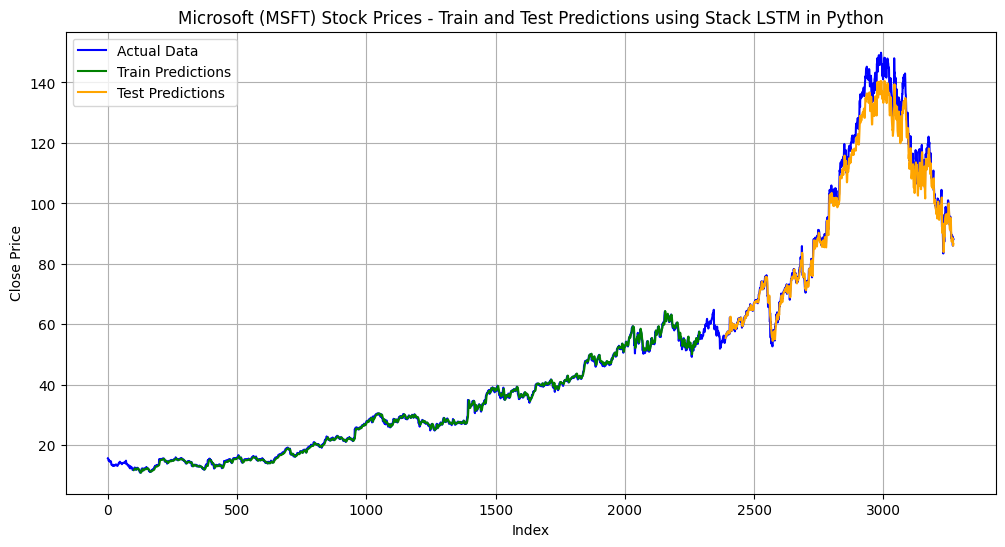

In [15]:
# Ensure that df1_scaled is also inverse transformed to original scale
df1_original = scaler.inverse_transform(df1_scaled)

# Plotting train and test predictions along with actual data
plt.figure(figsize=(12, 6))

# Creating empty arrays for plotting train and test predictions
trainPredictPlot = np.empty_like(df1_original)
trainPredictPlot[:, :] = np.nan
testPredictPlot = np.empty_like(df1_original)
testPredictPlot[:, :] = np.nan

# Plotting train predictions
train_pred_index = np.arange(time_step, time_step + len(y_train_pred))
trainPredictPlot[train_pred_index] = y_train_pred

# Plotting test predictions
test_pred_index = np.arange(len(df1_original) - len(y_test_pred), len(df1_original))
testPredictPlot[test_pred_index] = y_test_pred

# Plotting actual data
plt.plot(df1_original, label='Actual Data', color='blue')

# Plotting train predictions
plt.plot(trainPredictPlot, label='Train Predictions', color='green')

# Plotting test predictions
plt.plot(testPredictPlot, label='Test Predictions', color='orange')

plt.title('Microsoft (MSFT) Stock Prices - Train and Test Predictions using Stack LSTM in Python')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [16]:

# Predicting future prices for the next 15 days
future_predictions = []
last_sequence = df1_scaled[-time_step:].reshape(1, time_step, 1)  # Start prediction from the last sequence of the data

for _ in range(15):
    future_prediction = model.predict(last_sequence)[0][0]
    future_predictions.append(future_prediction)
    last_sequence = np.append(last_sequence[:, 1:, :], np.array([[future_prediction]]).reshape(1, 1, 1), axis=1)  # Update the sequence for the next prediction

# Inverse transforming future predictions to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

1/1 [==============================] - 0s 24ms/step


In [18]:
# Generate date range for future predictions
end_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=end_date, periods=15 + 1, freq='B')[1:]
dates_list = [str(date) for date in future_dates]
dates_list

['2023-01-02 00:00:00',
 '2023-01-03 00:00:00',
 '2023-01-04 00:00:00',
 '2023-01-05 00:00:00',
 '2023-01-06 00:00:00',
 '2023-01-09 00:00:00',
 '2023-01-10 00:00:00',
 '2023-01-11 00:00:00',
 '2023-01-12 00:00:00',
 '2023-01-13 00:00:00',
 '2023-01-16 00:00:00',
 '2023-01-17 00:00:00',
 '2023-01-18 00:00:00',
 '2023-01-19 00:00:00',
 '2023-01-20 00:00:00']

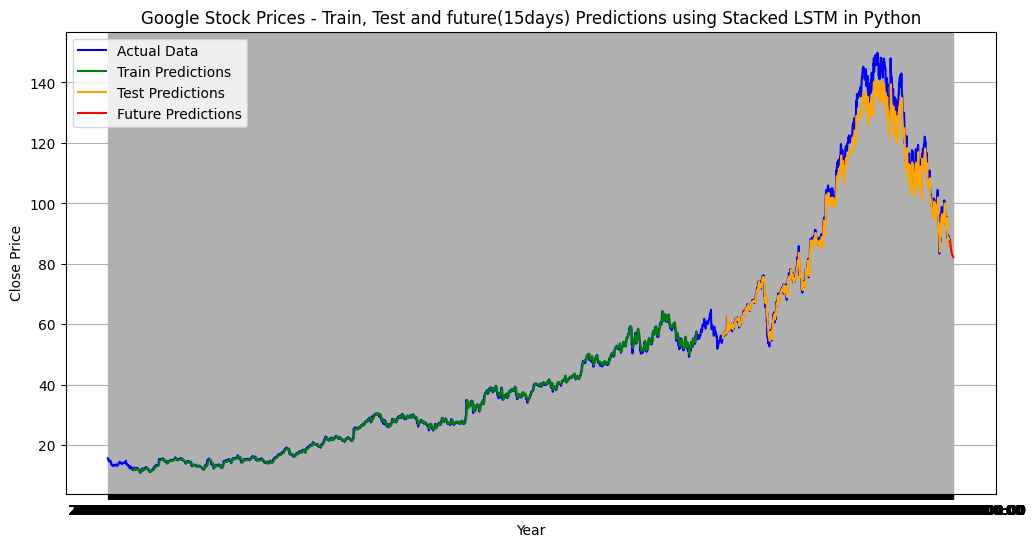

Future Predictions for the next 15 days:
Day 1: 87.5283432006836
Day 2: 87.40538024902344
Day 3: 86.88578033447266
Day 4: 86.22909545898438
Day 5: 85.52957916259766
Day 6: 84.85130310058594
Day 7: 84.24579620361328
Day 8: 83.74517059326172
Day 9: 83.35903930664062
Day 10: 83.07696533203125
Day 11: 82.87423706054688
Day 12: 82.71898651123047
Day 13: 82.57898712158203
Day 14: 82.42709350585938
Day 15: 82.24492645263672


In [21]:
# Generate date range for future predictions
# end_date = df['date'].iloc[-1]
# future_dates = pd.date_range(start=end_date, periods=15 + 1, freq='B')[1:]
# future_dates
# Plotting actual data
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df1_original, label='Actual Data', color='blue')

# Plotting train predictions
plt.plot(df['Date'].iloc[train_pred_index], trainPredictPlot[train_pred_index], label='Train Predictions', color='green')

# Plotting test predictions
plt.plot(df['Date'].iloc[test_pred_index], testPredictPlot[test_pred_index], label='Test Predictions', color='orange')

# Plotting future predictions
plt.plot(dates_list, future_predictions, label='Future Predictions', color='red')

plt.title('Google Stock Prices - Train, Test and future(15days) Predictions using Stacked LSTM in Python')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Print future predictions
print("Future Predictions for the next 15 days:")
for i, pred in enumerate(future_predictions):
    print(f"Day {i + 1}: {pred[0]}")